# Imports, project constants and functions

In [30]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Simulation functions

In [2]:
def generate_data_points(A, B, x0, n_point):
    noise_shape = x0.shape + (n_point,)
    w = np.random.randn(*noise_shape)
    data_points = np.zeros(shape=noise_shape)
    # data_points[..., 0] = x0
    x = x0
    for i in range(n_point):
        x = A @ x + B @ w[..., i]
        data_points[..., i] = x
    return data_points

def generate_measurements(H, data_points, R_array, n_point, node_number):
    # H: (n - number of nodes, m - length of x vector) 
    # data_points: (n - length of x vector, 1, n_point)
    H_expand = H[np.newaxis, ...].repeat(n_point, 0)
    data_points = data_points[np.newaxis, ...].repeat(node_number, 0)
    data_points_reorder = np.transpose(data_points, axes=(3, 0, 1, 2))
    R_matrix_array = R_array[np.newaxis, ...].repeat(n_point, 0)
    # print(H_expand.shape, data_points_reorder.shape)
    z = H_expand @ data_points_reorder
    # print(z.shape)
    v = np.random.randn(*z.shape)
    # print(R_matrix_array.shape, v.shape)
    measurements = z + np.sqrt(R_matrix_array)[..., np.newaxis, np.newaxis] @ v
    return measurements

def set_simulation():
    A0 = 2 * np.array([[0, -1], [1, 0]])
    A = np.eye(2) + eps * A0 + (((eps * A0) ** 2) / 2) + (((eps * A0) ** 3) / 6)
    B = eps * cw * np.eye(2)
    n, p = 1, .5  # number of trials, probability of each trial
    s = np.random.binomial(n, p, (node_number,1))
    Hx = np.array([[1, 0],])
    Hy = np.array([[0, 1],])
    H = Hx * s + Hy * (1-s)
    H = H[:, np.newaxis, :]
    R_array = (30**2) * np.sqrt(np.arange(1, node_number+1))
    data_points = generate_data_points(A, B, x0, n_point)
    meas = generate_measurements(H, data_points, R_array, n_point, node_number)
    return data_points, meas, H, R_array


## kalman filter functions

In [45]:
def global_kalman_fiter(measurments, H, R_array, P0, A, B):
    x_hat = np.zeros((1000, 2, 1))
    H = H.reshape((-1, 2))
    measurments = measurments.reshape((measurments.shape[0], -1, 1))
    R_matrix = np.diag(R_array)
    P = P0
    x_pred = np.array([[0, 0],]).T
    for i in range(measurments.shape[0]):
        S = H @ P @ H.T + R_matrix
        y_pred = H @ x_pred
        kalman_gain = P @ H.T @ np.linalg.inv(S)
        delta_y = measurments[i, ...] - y_pred
        x_current = x_pred + kalman_gain @ delta_y
        M = P - kalman_gain @ S @ kalman_gain.T
        x_pred = A @ x_current
        P = A @ M @ A.T + B @ np.eye(2) @ B.T
        x_hat[i, ...] = x_current
    return x_hat
    
def central_kalman_fiter(measurments, H, R_array, P0, j_matrix, A, B):
    x_hat = np.zeros((1000, 2, 1))
    H_T = np.transpose(H, (0, 2, 1))
    R_inv = 1 / R_array
    node_s = H_T @ R_inv[:, np.newaxis, np.newaxis] @ H
    y_node = H_T @ R_inv[:, np.newaxis, np.newaxis] @ measurments
    s_all = node_s.sum(0) / j_mat.shape[0]
    y_all = y_node.sum(1) / j_mat.shape[0]
    P_pred = j_matrix.shape[0] * P0
    x_pred = np.array([[0, 0],]).T
    # x_pred = x0
    for i in range(measurments.shape[0]):
        M = np.linalg.inv(np.linalg.inv(P_pred) + s_all)
        x_current = x_pred + M @ (y_all[i,...] - s_all @ x_pred)
        P_pred = A @ M @ A.T + j_matrix.shape[0] * B @ np.eye(2) @ B.T
        x_pred = A @ x_current
        x_hat[i, ...] = x_current
    return x_hat

def local_kalman_fiter(measurments, H, R_array, P0, j_matrix, A, B):
    x_hat = np.zeros((1000, 50, 2, 1))
    H_T = np.transpose(H, (0, 2, 1))
    R_inv = 1 / (R_array)
    node_s = H_T @ R_inv[:, np.newaxis, np.newaxis] @ H
    y_node = H_T @ R_inv[:, np.newaxis, np.newaxis] @ measurments
    s_all_local = np.einsum('ij, jmk -> imk', j_matrix, node_s) / j_mat.sum(axis=0)[..., None, None]
    y_all_local = np.einsum('ij, njmk -> nimk', j_matrix, y_node) / j_mat.sum(axis=0)[..., None, None]
    # s_all_local = np.einsum('ij, jmk -> imk', j_matrix, node_s)
    # y_all_local = np.einsum('ij, njmk -> nimk', j_matrix, y_node)
    P_pred = j_mat.sum(axis=0)[..., None, None] * P0
    x_pred = np.array([[0, 0],]).T
    # x_pred = x0
    for i in range(measurments.shape[0]):
        M = np.linalg.inv(np.linalg.inv(P_pred) + s_all_local)
        x_current = x_pred + M @ (y_all_local[i, ...] - s_all_local @ x_pred)
        P_pred = A @ M @ A.T + j_mat.sum(axis=0)[..., None, None] * B @ np.eye(2) @ B.T
        x_pred = A @ x_current
        x_hat[i, ...] = x_current
    return x_hat

def alg_3_kalman_filter(measurments, H, R_array, P0, j_matrix, A, B):
    x_hat = np.zeros((1000, 50, 2, 1))
    H_T = np.transpose(H, (0, 2, 1))
    R_inv = 1 / R_array
    node_s = H_T @ R_inv[:, np.newaxis, np.newaxis] @ H
    y_node = H_T @ R_inv[:, np.newaxis, np.newaxis] @ measurments
    s_all_local = np.einsum('ij, jmk -> imk', j_matrix, node_s) / j_mat.sum(axis=0)[..., None, None]
    y_all_local = np.einsum('ij, njmk -> nimk', j_matrix, y_node) / j_mat.sum(axis=0)[..., None, None]
    P_pred = j_mat.sum(axis=0)[..., None, None] * P0
    x_pred = np.array([[0, 0],]).T
    for i in range(measurments.shape[0]):
        M = np.linalg.inv(np.linalg.inv(P_pred) + s_all_local)
        if i == 0:
            x_current = x_pred + M @ (y_all_local[i, ...] - s_all_local @ x_pred)
            x_current[np.isinf(x_current)] = 0
        else:
            x_diff_pred_neighborhood = (np.einsum('ij, jmk -> imk', j_matrix, x_pred) - j_mat.sum(axis=0)[..., None, None] * x_pred)
            x_diff_pred_neighborhood = x_diff_pred_neighborhood / j_mat.sum(axis=0)[..., None, None]
            # print(x_diff_pred_neighborhood)
            x_current = x_pred + M @ (y_all_local[i, ...] - s_all_local @ x_pred) +  0.2 * x_diff_pred_neighborhood
        P_pred = A @ M @ A.T + j_mat.sum(axis=0)[..., None, None] * B @ np.eye(2) @ B.T
        x_pred = A @ x_current
        x_hat[i, ...] = x_current
    return x_hat

## constants

In [29]:
np.random.seed(42)
n_point = 1000
node_number = 50
eps = 0.015
cw = 25
x0 = np.array([[15, -10],]).T
P0 = 10 * np.eye(2)

# Simulate our system

In [5]:
A0 = 2 * np.array([[0, -1], [1, 0]])
A = np.eye(2) + eps * A0 + (((eps * A0) ** 2) / 2) + (((eps * A0) ** 3) / 6)
B = eps * cw * np.eye(2)

In [6]:
n, p = 1, .5  # number of trials, probability of each trial
s = np.random.binomial(n, p, (node_number,1))
Hx = np.array([[1, 0],])
Hy = np.array([[0, 1],])
H = Hx * s + Hy * (1-s)
H = H[:, np.newaxis, :]
R_array =  30 * np.sqrt(np.arange(1, node_number+1))

In [7]:
data_points = generate_data_points(A, B, x0, n_point)
data_points.shape

(2, 1, 1000)

In [8]:
meas = generate_measurements(H, data_points, R_array, n_point, node_number)
meas.shape

(1000, 50, 1, 1)

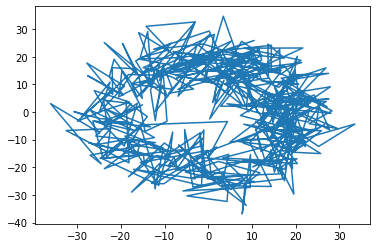

In [9]:
plt.plot(meas[:500, 0, 0, 0], meas[:500, 1, 0, 0] )

In [10]:
# H.shape
print(R_array.shape)
H_T = np.transpose(H, (0, 2, 1))
print(H.shape)
print(H_T.shape)
a = H_T @ (1/R_array)[:, np.newaxis, np.newaxis] @ H
a.shape
# np.matmul(R_matrix, H_T).shape

(50,)
(50, 1, 2)
(50, 2, 1)


(50, 2, 2)

In [11]:
(H_T @ (1/R_array)[:, np.newaxis, np.newaxis]).shape

(50, 2, 1)

In [12]:
((H_T @ (1/R_array)[:, np.newaxis, np.newaxis]) @ meas).shape

(1000, 50, 2, 1)

In [13]:
y = H_T @ (1/R_array)[:, np.newaxis, np.newaxis] @ meas
y.shape

(1000, 50, 2, 1)

# Creating Graph

In [14]:
g = nx.connected_watts_strogatz_graph(node_number, 4, 0.4, seed=42)

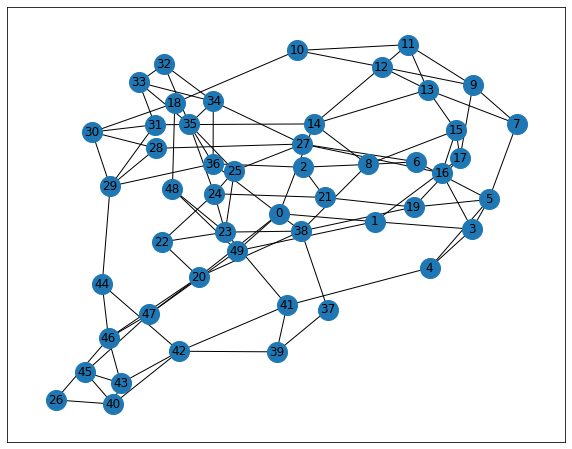

In [15]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(g, node_size=400)

In [16]:
adj_matrix = nx.adjacency_matrix(g)

In [17]:
(adj_matrix @ adj_matrix[:,[-1]].todense()).sum()

15

In [18]:
adj_matrix + np.eye(node_number)

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.]])

In [19]:
meas[...,0,:].shape

(1000, 50, 1)

In [20]:
((adj_matrix + np.eye(node_number)) @ meas[...,0,:]).shape

(1000, 50, 1)

In [21]:
s_all = np.einsum('ij, jmk -> imk', (adj_matrix + np.eye(node_number)), a)

In [22]:

a[(adj_matrix + np.eye(node_number))[0, :].astype(bool), ...].sum(axis=0)

array([[0.03084416, 0.        ],
       [0.        , 0.04665401]])

In [23]:
s_all.shape

(50, 2, 2)

In [46]:
preds_local = []
preds_alg3 = []
preds_central = []
preds_global = []
data_points_stack = []
# data_points, meas = set_simulation()
for _ in tqdm(range(10)):
    g = nx.connected_watts_strogatz_graph(node_number, 5, 0.4, seed=42)
    adj_matrix = nx.adjacency_matrix(g)
    data_points, meas, H, R_array = set_simulation()
    data_points_stack.append(data_points.transpose(-1, 0, 1))
    j_mat = adj_matrix + np.eye(node_number)
    kalman_pred_global = global_kalman_fiter(meas, H, R_array, P0, A, B)
    kalman_pred_alg_3 = alg_3_kalman_filter(meas, H, R_array, P0, j_mat, A, B)
    kalman_pred_local = local_kalman_fiter(meas, H, R_array, P0, j_mat, A, B)
    # kalman_pred_central = central_kalman_fiter(meas, H, R_array, P0, j_mat, A, B)
    preds_local.append(kalman_pred_local)
    preds_alg3.append(kalman_pred_alg_3)
    preds_central.append(kalman_pred_central)
    preds_global.append(kalman_pred_global)
preds_local = np.stack(preds_local)
preds_alg3 = np.stack(preds_alg3)
preds_central = np.stack(preds_central)
preds_global = np.stack(preds_global)
data_points_stack = np.stack(data_points_stack)

100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


In [47]:
err_local = np.linalg.norm(preds_local - data_points_stack[:, :, np.newaxis, ...].repeat(node_number, axis=2), axis=-2).mean(-2).mean(axis=0)
err_alg3 = np.linalg.norm(preds_alg3 - data_points_stack[:, :, np.newaxis, ...].repeat(node_number, axis=2), axis=-2).mean(-2).mean(axis=0)
err_central = np.linalg.norm(preds_central - data_points_stack, axis=-2).mean(axis=0)
err_global = np.linalg.norm(preds_global - data_points_stack, axis=-2).mean(axis=0)

In [48]:
preds_global.shape

(10, 1000, 2, 1)

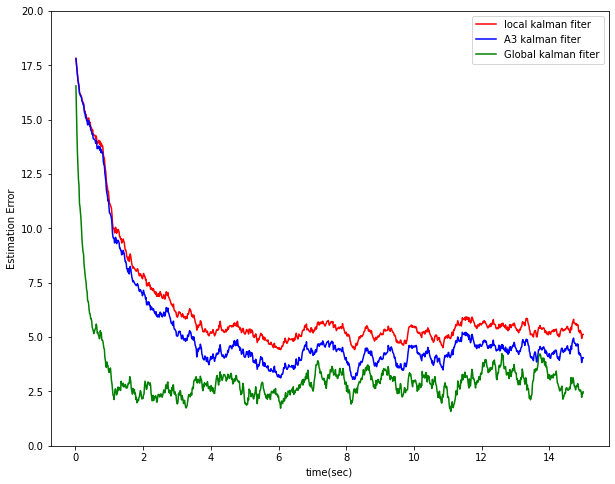

In [50]:
time = np.arange(1000) * eps + eps
step = 1
plt.figure(figsize=(10, 8))
plt.plot(time[::step], err_local[::step], 'r', label='local kalman fiter')
plt.plot(time[::step], err_alg3[::step], 'b', label='A3 kalman fiter')
# plt.plot(time[::step], err_central[::step], 'y', label='Centralized kalman fiter')
plt.plot(time[::step], err_global[::step], 'g', label='Global kalman fiter')
plt.xlabel('time(sec)')
plt.ylabel('Estimation Error')
plt.ylim([0, 20])
plt.legend()
plt.show()

In [119]:
disagreement = np.sqrt(((preds_local - preds_local.mean(axis=-3)[:, :, None, :, :])**2).sum(axis=(-2, -3))).mean(0)
disagreement_alg3 = np.sqrt(((preds_alg3 - preds_alg3.mean(axis=-3)[:, :, None, :, :])**2).sum(axis=(-2, -3))).mean(0)
# disagreement_central = np.sqrt(((preds_central - preds_central.mean(axis=-3)[:, :, None, :, :])**2).sum(axis=(-2, -3))).mean(0)
disagreement.shape

(1000, 1)

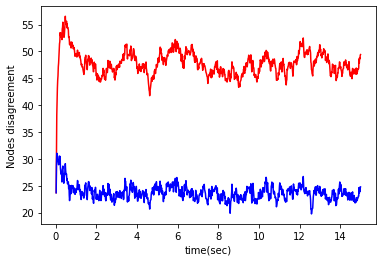

In [120]:
plt.plot(time, disagreement, 'r')
plt.plot(time, disagreement_alg3, 'b')
plt.xlabel('time(sec)')
plt.ylabel('Nodes disagreement')
# plt.plot(time, disagreement_central, 'y')
plt.show()